# Kaggle
## Titanic: Machine Learning from Disaster

In [1]:
# 加载包
import pandas as pd
import numpy as np
import xgboost as xgb

## 步骤

- 1.加载数据
- 2.观察训练数据分布
- 3.处理特征
- 4.训练模型
- 5.验证

## 1 加载数据

In [2]:
train_data = pd.read_csv("/Users/Nelson/Desktop/Computer/Kaggle/Titanic/datasets/train.csv")
test_data = pd.read_csv("/Users/Nelson/Desktop/Computer/Kaggle/Titanic/datasets/test.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


可以看到训练数据中的Age和Cabin缺失较为严重，而Embarked缺失2个，可以用众数填充。其他特征无缺失。

In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从上面的数据可以看到以下结果：

- 整个训练数据集中只有大概38.4%人获救
- 乘客的平均年龄大约为29.7岁
- 舱位中的2、3等舱人比1等舱的人多，说明有钱人还是少数
- 从SibSp和Parch可以大概看到，平均一个人有0.9（接近1）个家属在船上，但是可以看到SibSp和Parch的方差还是很大的
- 平均的船票价格是32刀，最贵512刀

# 2 Analysis Data
对训练数据中的每一个特征进行分析，从而实现对每个特征的合理处理。

- PassengerId 没有太大用，可以drop掉
- Survived 样本标记
- Pclass 乘客的仓位信息，即类似头等舱、普通舱的信息，可以反映乘客不同的身份。由于是定序变量，需要进行one-hot编码
- Name 可以发现人名中有一些身份信息，例如Miss，Mr，Master等信息，可以作为一个特征
- Sex 性别信息，需要进行one-hot编码
- Age 连续数据，需要进行年龄段划分（离散化），减少误差
- SibSp 乘客在船上的兄弟姐妹。一般来说，有兄弟姐妹的乘客是否能逃生一般会受到兄弟姐妹的影响，兄弟姐妹一般都会在一起
- parch 同上
- Ticket 船票一般都是连号的，所以说船票信息能反映乘客相对位置，位置对于乘客是否能逃生也有很大的影响
- Fare 客运票价，需要进行离散化
- Cabin 船舱编号，可以看到缺失值太多，直接丢弃
- Embarked 上船港口，不同地区上船的乘客在船上的位置可能不同，会对逃生带来影响

## 2.1 观察分布


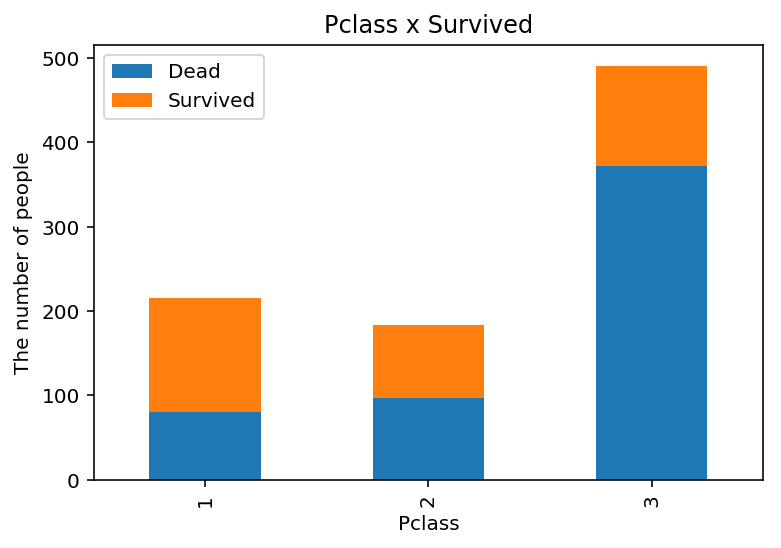

In [126]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

survived_0 = train_data[train_data['Survived']==0]
survived_1 = train_data[train_data['Survived']==1]

# 绘制舱位的分布图
df_Pclass = pd.DataFrame({'Survived': survived_1['Pclass'].value_counts(), 'Dead': survived_0['Pclass'].value_counts()})
df_Pclass.plot(kind='bar', stacked=True)
plt.title("Pclass x Survived")
plt.xlabel("Pclass")
plt.ylabel("The number of people")

从上面的分布可以得到两个结论：

- 一等舱的乘客被救出的几率最大
- 三等舱乘客被救出的几率最小
- 因此舱位是影响逃生的很重要的因素

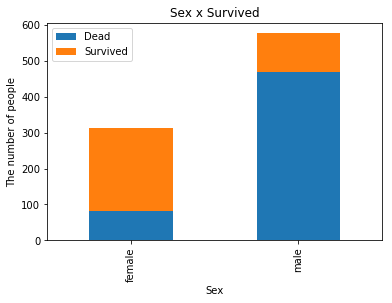

In [14]:
# 性别的获救情况
df_Sex = pd.DataFrame({'Survived': survived_1['Sex'].value_counts(), 'Dead': survived_0['Sex'].value_counts()})
df_Sex.plot(kind='bar', stacked=True)
plt.title("Sex x Survived")
plt.xlabel("Sex")
plt.ylabel("The number of people")

从上面的分布可以得到结论：男性的获救率很低，女性的获救率很高。其实另一个隐藏的内容是，Titanic当时要求小孩女人先撤，所以小孩其实获救率也很高。所以性别是一项重要因素。

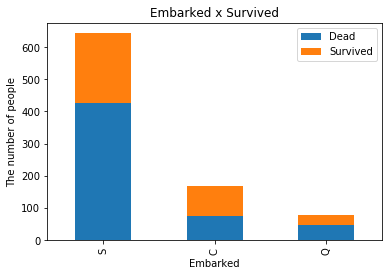

In [18]:
# embarked港口的获救情况
# 港口数据有两个缺失值，我们对其进行填充
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
df_Embarked = pd.DataFrame({'Survived': survived_1['Embarked'].value_counts(), 'Dead': survived_0['Embarked'].value_counts()})
df_Embarked.plot(kind='bar', stacked=True)
plt.title("Embarked x Survived")
plt.xlabel("Embarked")
plt.ylabel("The number of people")

可以看出，C舱的获救率最高，而S和Q舱的获救率相对较低，因此Embarked也是重要特征

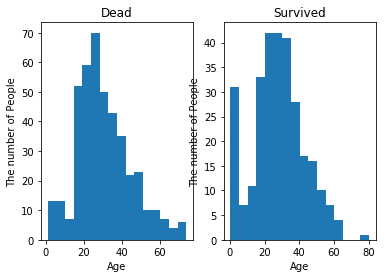

In [52]:
# 观察年龄分布(排除缺失值)
fig = plt.figure()
fig.set(alpha=0.2)

plt.subplot2grid((1,2), (0,0))
plt.hist(survived_0[survived_0['Age'].notnull()]['Age'], bins='auto')
plt.title("Dead")
plt.xlabel("Age")
plt.ylabel("The number of People")

plt.subplot2grid((1,2), (0,1))
plt.hist(survived_1[survived_1['Age'].notnull()]['Age'], bins='auto')
plt.title("Survived")
plt.xlabel("Age")
plt.ylabel("The number of People")

从上面的数据可以明显看出在逃生的人中，存在年龄特别小的人数相当的多，这也印证了小孩逃生率更高的说法。除了小孩以外，逃生的人中其他年龄段分布基本相似，所以年龄的划分可以划分为是否为小孩（10岁以下）。

/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


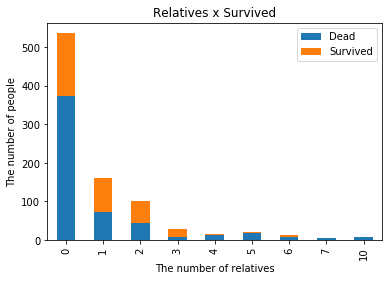

In [61]:
# 接下来看一下SibSp和Parch数据，这两列数据代表了是否有亲属在，SibSp代表兄弟姐妹，而Parch代表是否有小孩或者父母。
# 我们把这两列进行相加，只关系家属状况，而不区分是否为兄弟姐妹或者是否是孩子父母
survived_0['Relatives'] = survived_0['SibSp'] + survived_0['Parch']
survived_1['Relatives'] = survived_1['SibSp'] + survived_1['Parch']
df_Relatives = pd.DataFrame({'Survived': survived_1['Relatives'].value_counts(), 'Dead': survived_0['Relatives'].value_counts()})
df_Relatives.plot(kind='bar', stacked=True)
plt.title("Relatives x Survived")
plt.xlabel("The number of relatives")
plt.ylabel("The number of people")

从图中可以看出家属小于等于3的人更容易获救（获救率较高），而家属人数超过3的乘客几乎都遇难了。因此在后面对Relatives这一列进行0-1划分，判断是否小于3

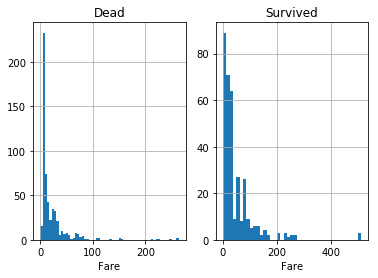

In [72]:
# 观察Fare的分布
fig = plt.figure()
fig.set(alpha=0.2)

plt.subplot2grid((1,2), (0,0))
survived_0['Fare'].hist(bins='auto')
plt.title("Dead")
plt.xlabel("Fare")

plt.subplot2grid((1,2), (0,1))
survived_1['Fare'].hist(bins='auto')
plt.title("Survived")
plt.xlabel("Fare")

Fare暂时看不出什么特别之处，当做一半的连续数据进行归一化处理

Ticket暂时不进行处理

In [75]:
# 观察Cabin
pd.value_counts(train_data['Cabin'].isnull())

True     687
False    204
Name: Cabin, dtype: int64

/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


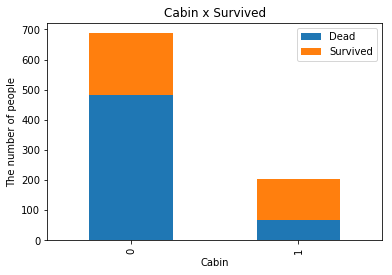

In [82]:
# 可以看到Cabin缺失相当严重，我们队Cabin进行一步处理
# 填充空缺为‘Unknown’
survived_0['Cabin'].fillna('Unknown', inplace=True)
survived_1['Cabin'].fillna('Unknown', inplace=True)
# 抽取Cabin的字母
survived_0['Cabin_No'] = map(lambda x: int(x!='Unknown'), survived_0['Cabin'])
survived_1['Cabin_No'] = map(lambda x: int(x!='Unknown'), survived_1['Cabin'])
# 绘图
df_Cabin = pd.DataFrame({'Survived': survived_1['Cabin_No'].value_counts(), 'Dead': survived_0['Cabin_No'].value_counts()})
df_Cabin.plot(kind='bar', stacked=True)
plt.title("Cabin x Survived")
plt.xlabel("Cabin")
plt.ylabel("The number of people")

开始我把空值填充为Unknown以后再按照首字母来进行分布绘制，但是发现效果并不好。因此按照有无Cabin来进行划分。可以看出有Cabin的乘客更多地被获救。因此Cabin一列按照有无Cabin来处理。

In [91]:
# 处理Ticket
# 对ticket按照上述方式处理
# 编辑正则
import re
pattern_num = re.compile(r"^\d+$") # 纯数字
pattern_A = re.compile(r"^A.*") # A开头
pattern_C = re.compile(r"^C.*") # C开头
pattern_F = re.compile(r"^F.*") # F开头
pattern_LINE = re.compile(r"^LINE") # LINE
pattern_P = re.compile(r"^P.*") # P开头
pattern_S = re.compile(r"^S.*") # S开头
pattern_W = re.compile(r"^W.*") # W开头
def process_ticket(ticket):
    length = len(ticket)
    if re.match(pattern_num, ticket):
        return 1
    elif re.match(pattern_A, ticket):
        return 2
    elif re.match(pattern_C, ticket):
        return 3
    elif re.match(pattern_F, ticket):
        return 4
    elif re.match(pattern_LINE, ticket):
        return 5
    elif re.match(pattern_P, ticket):
        return 6
    elif re.match(pattern_S, ticket):
        return 7
    elif re.match(pattern_W, ticket):
        return 8
    else:
        return 9

/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nelson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


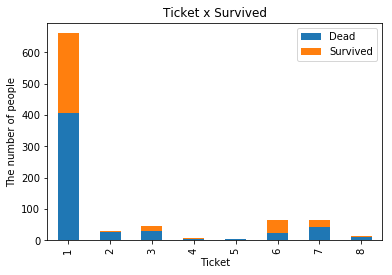

In [92]:
survived_0['Ticket_new'] = map(process_ticket, survived_0['Ticket'])
survived_1['Ticket_new'] = map(process_ticket, survived_1['Ticket'])

df_Ticket = pd.DataFrame({'Survived': survived_1['Ticket_new'].value_counts(), 'Dead': survived_0['Ticket_new'].value_counts()})
df_Ticket.plot(kind='bar', stacked=True)
plt.title("Ticket x Survived")
plt.xlabel("Ticket")
plt.ylabel("The number of people")

对Ticket进行进一步处理并没有发现什么好的特征，因此放弃Ticket这一列，对其他列进行处理。

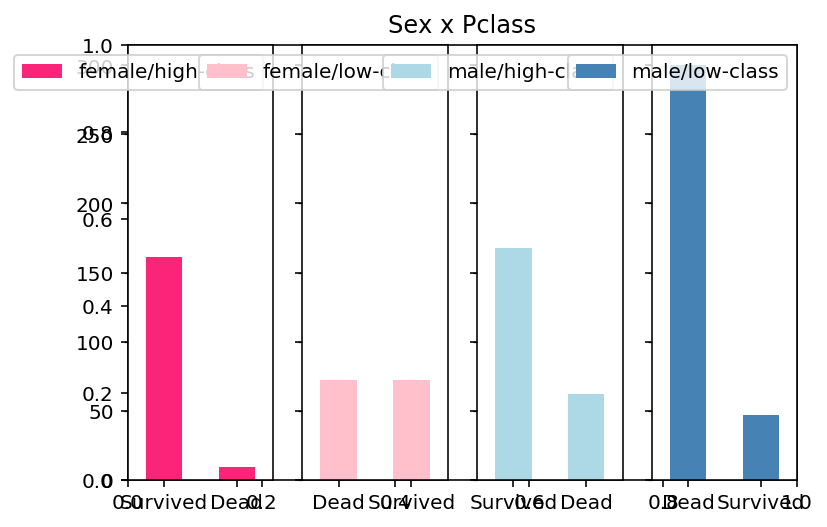

In [127]:
# 交叉属性的观察
fig = plt.figure()
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title("Sex x Pclass")

ax1=fig.add_subplot(141)
train_data.Survived[train_data.Sex == 'female'][train_data.Pclass != 3].value_counts().plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels(['Survived', 'Dead'], rotation=0)
ax1.legend(['female/high-class'], loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
train_data.Survived[train_data.Sex == 'female'][train_data.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels(['Dead', 'Survived'], rotation=0)
plt.legend(['female/low-class'], loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
train_data.Survived[train_data.Sex == 'male'][train_data.Pclass != 3].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax3.set_xticklabels(['Survived', 'Dead'], rotation=0)
plt.legend(['male/high-class'], loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
train_data.Survived[train_data.Sex == 'male'][train_data.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax4.set_xticklabels(['Dead', 'Survived'], rotation=0)
plt.legend(['male/low-class'], loc='best')

plt.show()

# 3 Feature Processing

one-hot处理：

- Pclass
- Sex
- Embarked

离散化处理：

- Age预测填充，<10岁为1，其余为0
- Parch和SibSp进行加和生成Relatives，对Relatives以 <4进行区间划分。
- Cabin 按照有无Cabin处理

归一化处理：

- Fare

丢弃：

- Ticket

由于训练集和测试集需要相同的处理过程，因此在下面我们将把训练集和测试集的特征数据单独拿出来进行preprocessing，该部分的步骤如下：

- 1.合并训练集与测试集的特征，将训练集的targets分离出来后续再合并
- 2.对特征数据进行处理
- 3.分离训练集和测试集
- 4.模型训练与验证
- 5.提交结果

## 3.1 合并两部分特征
- train_features: 训练样本的特征
- train_targets: 训练样本的标记
- test_features: 测试样本的特征

In [148]:
# 合并两部分特征
train_features, train_targets = train_data.drop('Survived', axis=1), train_data['Survived']
test_features = test_data
features = pd.concat([train_features, test_features], ignore_index=True)

In [149]:
features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3.2 特征处理

In [150]:
# (1)首先对Pclass， Sex以及 Embarked进行one-hot编码
onehot_fields = ['Pclass', 'Sex', 'Embarked']
# Embarked用众数进行空值填充
features['Embarked'].fillna(features['Embarked'].mode()[0], inplace=True)

for each in onehot_fields:
    onehot_result = pd.get_dummies(features[each], prefix=each)
    features = pd.concat([features, onehot_result], axis=1)
    features.drop(each, axis=1, inplace=True)

In [151]:
# (2)对Parch和SibSp进行处理
features['Relatives'] = features['SibSp'] + features['Parch']
# 按照Relatives<4分开
features['Relatives_new'] = map(lambda x: int(x < 4), features['Relatives'])
# 对Relatives_new进行one-hot编码
onehot_result = pd.get_dummies(features['Relatives_new'], prefix='Relatives')
features = pd.concat([features, onehot_result], axis=1)

features.drop(['SibSp', 'Parch', 'Relatives', 'Relatives_new'], axis=1, inplace=True)

In [152]:
# (3)对Cabin进行有无Cabin进行处理
features['Cabin_new'] = map(int, features['Cabin'].notnull())
# one-hot编码
onehot_result = pd.get_dummies(features['Cabin_new'], prefix='Cabin')
features = pd.concat([features, onehot_result], axis=1)

features.drop(['Cabin', 'Cabin_new'], axis=1, inplace=True)

In [153]:
# (4)对Fare进行归一化处理
fare_mean = np.mean(features['Fare'])
# 填充缺失值
features['Fare'].fillna(fare_mean, inplace=True)
fare_std = np.std(features['Fare'])
features['Fare_scaled'] = (features['Fare'] - fare_mean) / fare_std

features.drop('Fare', axis=1, inplace=True)

In [154]:
features.head()

,PassengerId,Name,Age,Ticket,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Relatives_0,Relatives_1,Cabin_0,Cabin_1,Fare_scaled
0,1,"Braund, Mr. Owen Harris",22.0,A/5 21171,0,0,1,0,1,0,0,1,0,1,1,0,-0.503595
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,1,0,0,1,0,1,0,0,0,1,0,1,0.734503
2,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,0,0,1,1,0,0,0,1,0,1,1,0,-0.490544
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,1,0,0,1,0,0,0,1,0,1,0,1,0.382925
4,5,"Allen, Mr. William Henry",35.0,373450,0,0,1,0,1,0,0,1,0,1,1,0,-0.488127


In [155]:
# (5)名字中间会代表该乘客的称号，我们对其进行统计
# 一层数据映射
def get_middle_name(name):
    try:
        title = name.split(",")[1].split(".")[0].strip().lower()
    except:
        title = None
    return title

In [156]:
features['Title'] = map(get_middle_name, features['Name'])

In [157]:
# 将部分title进行合并
def combine_titles(title):
    if title == "ms" or title == "mlle":
        return "miss"
    if title == "capt" or title == "col" or title == "don" or title == "major":
        return "sir"
    if title == "jonkheer":
        return "master"
    if title == "mme":
        return "mrs"
    if title == "dona" or title == "lady" or title == "the countess":
        return "lady"
    else:
        return title

In [158]:
features['Title'] = map(combine_titles, features['Title'])

In [159]:
# 对称号进行one-hot编码
features = pd.concat([features, pd.get_dummies(features['Title'], prefix='Title')], axis=1)
features.drop(['Name', 'Title'], axis=1, inplace=True)

In [168]:
features.head()

,PassengerId,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Fare_scaled,Title,Title_dr,Title_lady,Title_master,Title_miss,Title_mr,Title_mrs,Title_rev,Title_sir
0,1,22.0,0,0,1,0,1,0,0,1,...,-0.503595,mr,0,0,0,0,1,0,0,0
1,2,38.0,1,0,0,1,0,1,0,0,...,0.734503,mrs,0,0,0,0,0,1,0,0
2,3,26.0,0,0,1,1,0,0,0,1,...,-0.490544,miss,0,0,0,1,0,0,0,0
3,4,35.0,1,0,0,1,0,0,0,1,...,0.382925,mrs,0,0,0,0,0,1,0,0
4,5,35.0,0,0,1,0,1,0,0,1,...,-0.488127,mr,0,0,0,0,1,0,0,0


In [169]:
# # 对ticket按照上述方式处理
# # 编辑正则
# import re
# pattern_num = re.compile(r"^\d+$") # 纯数字
# pattern_A = re.compile(r"^A.*") # A开头
# pattern_C = re.compile(r"^C.*") # C开头
# pattern_F = re.compile(r"^F.*") # F开头
# pattern_LINE = re.compile(r"^LINE") # LINE
# pattern_P = re.compile(r"^P.*") # P开头
# pattern_S = re.compile(r"^S.*") # S开头
# pattern_W = re.compile(r"^W.*") # W开头
# def process_ticket(ticket):
#     length = len(ticket)
#     if re.match(pattern_num, ticket) and length == 7:
#         return 1
#     elif re.match(pattern_num, ticket) and length == 6:
#         return 2
#     elif re.match(pattern_num, ticket) and length == 5:
#         return 3
#     elif re.match(pattern_num, ticket) and length == 4:
#         return 4
#     elif re.match(pattern_A, ticket):
#         return 5
#     elif re.match(pattern_C, ticket):
#         return 6
#     elif re.match(pattern_F, ticket):
#         return 7
#     elif re.match(pattern_LINE, ticket):
#         return 8
#     elif re.match(pattern_P, ticket):
#         return 9
#     elif re.match(pattern_S, ticket):
#         return 10
#     elif re.match(pattern_W, ticket):
#         return 11
#     else:
#         return 12

In [170]:
# # features['Ticket_new'] = map(process_ticket, features['Ticket'])

# # 哑元化
# features = pd.concat([features, pd.get_dummies(features['Ticket_new'], prefix='Ticket')], axis=1)
# features.drop('Ticket', axis=1, inplace=True)

In [171]:
# (6)将Ticket扔掉
features.drop('Ticket', axis=1, inplace=True)

ValueError: labels ['Ticket'] not contained in axis

In [172]:
features.head()

,PassengerId,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Fare_scaled,Title,Title_dr,Title_lady,Title_master,Title_miss,Title_mr,Title_mrs,Title_rev,Title_sir
0,1,22.0,0,0,1,0,1,0,0,1,...,-0.503595,mr,0,0,0,0,1,0,0,0
1,2,38.0,1,0,0,1,0,1,0,0,...,0.734503,mrs,0,0,0,0,0,1,0,0
2,3,26.0,0,0,1,1,0,0,0,1,...,-0.490544,miss,0,0,0,1,0,0,0,0
3,4,35.0,1,0,0,1,0,0,0,1,...,0.382925,mrs,0,0,0,0,0,1,0,0
4,5,35.0,0,0,1,0,1,0,0,1,...,-0.488127,mr,0,0,0,0,1,0,0,0


对年龄进行离散化处理，首先需要填充缺失值，泰坦尼克号中，女人和小孩的存活率最高，所以年龄其实是一个很重要的特征，因此，需要需要对年龄进行预测。在这里，我们采用其他特征来对年龄进行预测，用随机森林来进行预测。

In [180]:
# 用随机森林填充年龄
from sklearn.ensemble import RandomForestRegressor
# 划分训练数据集和测试数据集
age_train_set = features[features['Age'].notnull()]
age_test_set = features[features['Age'].isnull()]

In [181]:
# 进行特征训练
age_train_features, age_train_targets = age_train_set.drop(['PassengerId', 'Age'], axis=1), age_train_set['Age']
age_test_features = age_test_set.drop(['PassengerId', 'Age'], axis=1)

In [182]:
# 训练数据
crg = RandomForestRegressor()
crg.fit(age_train_features.values, age_train_targets.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [183]:
preds = crg.predict(age_test_features.values)

In [184]:
# 填充Age
features.loc[features['Age'].isnull(), 'Age'] = preds

(array([  42.,   24.,   35.,   14.,   26.,   85.,  107.,  155.,  133.,
         164.,   92.,   94.,   81.,   50.,   46.,   41.,   32.,   26.,
          17.,   18.,   14.,    5.,    3.,    2.,    2.,    1.]),
 array([  0.17      ,   3.24038462,   6.31076923,   9.38115385,
         12.45153846,  15.52192308,  18.59230769,  21.66269231,
         24.73307692,  27.80346154,  30.87384615,  33.94423077,
         37.01461538,  40.085     ,  43.15538462,  46.22576923,
         49.29615385,  52.36653846,  55.43692308,  58.50730769,
         61.57769231,  64.64807692,  67.71846154,  70.78884615,
         73.85923077,  76.92961538,  80.        ]),
 <a list of 26 Patch objects>)

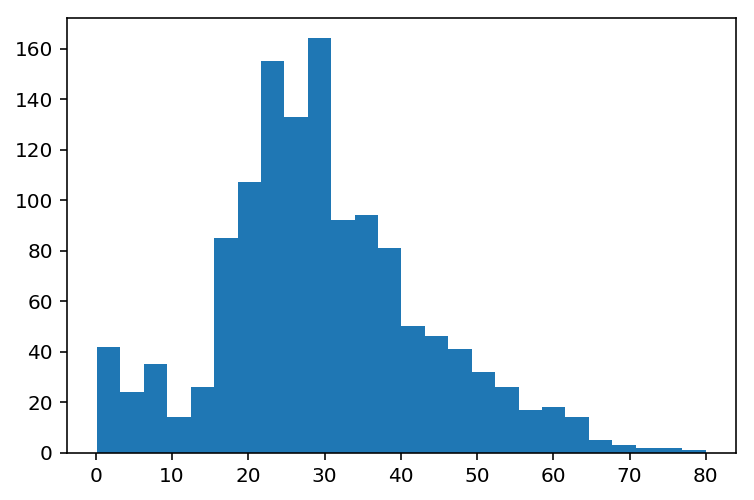

In [185]:
# 观察Age分布
plt.hist(features['Age'].values, bins='auto')

In [186]:
# 年龄离散化处理
def process_age(age):
    if age <= 12:
        return 1
    else:
        return 0

In [187]:
features['Age_new'] = map(process_age, features['Age'])

In [188]:
# 哑元化
features = pd.concat([features, pd.get_dummies(features['Age_new'], prefix='Age')], axis=1)

In [189]:
features.drop(['Age', 'Age_new'], axis=1, inplace=True)

# 4 建模
下面将利用xgboost进行建模，实现预测

In [213]:
# 设置参数
params = {
    'booster':'gbtree',
    'objective':'binary:logistic',# 输出概率
    'gamma':0.05, # 基学习器进行进一步分支的最小阈值，越大会越不容易过拟合（越保守）
    'max_depth':20, # the depth of tree
    'subsample':0.6, # the size of subsample
    'colsample_bytree':0.6, # the size of column subsample
    'silent':1,
    'eta':0.05, # learning rate，越小会越降低前面基学习器的权重
    'seed':710,
    'nthread':6
}
plst = list(params.items())

In [205]:
# 切割数据集
train_num = train_data.shape[0]
test_num = test_data.shape[0]
# 将特征切分
features.drop('PassengerId', axis=1, inplace=True)
trainset_features = features.iloc[:train_num, ].values
trainset_targets = train_data['Survived'].values

# 切分训练集和验证集
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(trainset_features, trainset_targets, test_size=0.3, random_state=123)
# test
X_test = features.iloc[train_num:, ].values

ValueError: labels ['PassengerId'] not contained in axis

In [206]:
# 转换成XBG格式
train = xgb.DMatrix(X_train, label=y_train)
val = xgb.DMatrix(X_val, label=y_val)
test = xgb.DMatrix(X_test)

In [207]:
watchlist = [(train, 'train'), (val, 'validation')]
num_rounds = 100

In [208]:
# 训练
model = xgb.train(plst, train, num_rounds, watchlist, early_stopping_rounds=20)

Will train until validation error hasn't decreased in 20 rounds.
[0]	train-error:0.211878	validation-error:0.231343
[1]	train-error:0.231140	validation-error:0.231343
[2]	train-error:0.224719	validation-error:0.205224
[3]	train-error:0.208668	validation-error:0.186567
[4]	train-error:0.192616	validation-error:0.175373
[5]	train-error:0.157303	validation-error:0.141791
[6]	train-error:0.152488	validation-error:0.141791
[7]	train-error:0.152488	validation-error:0.134328
[8]	train-error:0.155698	validation-error:0.149254
[9]	train-error:0.154093	validation-error:0.141791
[10]	train-error:0.147673	validation-error:0.141791
[11]	train-error:0.152488	validation-error:0.134328
[12]	train-error:0.160514	validation-error:0.149254
[13]	train-error:0.154093	validation-error:0.145522
[14]	train-error:0.154093	validation-error:0.145522
[15]	train-error:0.157303	validation-error:0.145522
[16]	train-error:0.158909	validation-error:0.145522
[17]	train-error:0.154093	validation-error:0.141791
[18]	trai

In [209]:
result = model.predict(test)

In [210]:
pred_label = map(lambda x: int(x>=0.5), result)

In [211]:
submission = zip(test_data['PassengerId'].values.tolist(), pred_label)

In [212]:
with open('/Users/Nelson/Desktop/Computer/Kaggle/Titanic/datasets/xgb_submission3.csv', 'a') as f:
    f.write('PassengerId,Survived\n')
    for row in submission:
        f.write(str(row[0]) + ',' + str(row[1]) + '\n')

# 总结
## 结果
提交结果为0.79426，排名1793/6800

## 反思
- Ticket数据没有利用
- 没有新生成的特征
- 没有做特征筛选
- 特征分布还需要进一步处理